# I-FGSM (Iterative Fast Gradient Sign Method) tutorial
This example demonstrates how to apply Iterative FGSM attack to a LeNet network trained on MNIST dataset. See [this](https://arxiv.org/pdf/1611.01236.pdf) paper for far detailed information about the attack.

## Train LeNet on MNIST

In [1]:
using Knet
using Taarruz
using Images
using Plots

┌ Info: Recompiling stale cache file /kuacc/users/ikesen16/.julia/compiled/v1.1/Taarruz/e70oI.ji for Taarruz [edc76f5a-727d-11e9-15f5-7184c9a7c95d]
└ @ Base loading.jl:1184


In [2]:
Knet.seed!(1)
include(Knet.dir("data", "mnist.jl"))
dtrn, dtst = mnistdata()
lenet = Lenet()
progress!(adam(lenet, repeat(dtrn, 3)))
accuracy(lenet, dtst)

┌ Info: Loading MNIST...
└ @ Main /kuacc/users/ikesen16/.julia/packages/Knet/05UDD/data/mnist.jl:33


1.90e-01  100.00%┣██████████████████████████▉┫ 1800/1800 [00:17/00:17, 103.55i/s]


0.9897

## Abuse the Model
In this part, we measure the accuracy of our model, but we use the examples genearated with FGSM to abuse the model. As you can see, the accuracy drops nearly 50% percentage.

In [58]:
example1(x,y,ϵ=0.2,T=10,f=lenet) = IterativeFGSM(a->f(a,y),ϵ,T,x)[end][1]
abuse1(x,y,ϵ=0.2,T=10,f=lenet; o...) = accuracy(f(example1(x,y,ϵ,T,f)), y; o...)
abuse1(d::Knet.Data,ϵ=0.2,T=10,f=lenet) = sum(abuse1(x,y,ϵ,T,f; average=false) for (x,y) in d) / d.length
abuse1(dtst)

0.1687

In [ ]:
example2(x,y,ϵ=0.2,μ=0.2,T=10,f=lenet) = MomentumIterativeFGSM(a->f(a,y),ϵ,μ,T,x)[end][1]
abuse2(x,y,ϵ=0.2,μ=0.2,T=10,f=lenet; o...) = accuracy(f(example2(x,y,ϵ,μ,T,f)), y; o...)
abuse2(d::Knet.Data,ϵ=0.2,μ=0.2,T=10,f=lenet) = sum(abuse2(x,y,ϵ,μ,T,f; average=false) for (x,y) in d) / d.length
abuse2(dtst)

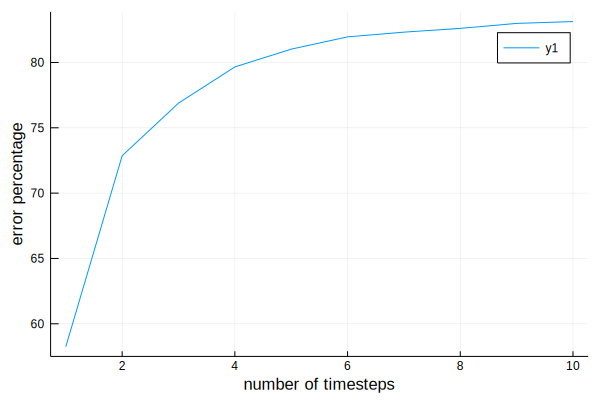

In [56]:
# using  Plots
Ts = 1:10
plot(Ts, [100-100*abuse(dtst,0.2,lenet,T) for T = Ts],
    xlabel="number of timesteps", ylabel="error percentage")

In [55]:
abuse(dtst,0.2,lenet,1)

0.4175

## Visualize Examples
Let's visualize the examples generated by the attack and observe how our model fails.

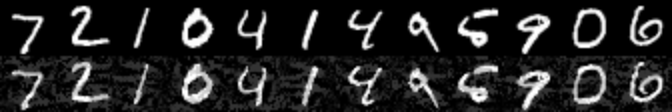

In [36]:
dtst.batchsize = 12 # to get 12 examples
x, y = first(dtst) # use rand to sample random images
ϵ = 0.2
T = 10
history = IterativeFGSM(a->lenet(a, y), ϵ, T, x)
x̂ = history[end][1]
image, noisy = Array(x), Array(x̂)
grid = vcat(
        hcat([mnistview(image, i) for i = 1:length(y)]...),
        hcat([mnistview(noisy, i) for i = 1:length(y)]...))
display(imresize(grid; ratio=2.))

Let's see how good our model performs on the real images and the perturbed images.

In [37]:
predict(x) = map(xi->rem(xi[1],10), argmax(Array(lenet(x)), dims=1))
print("predictions without the attack: "); println(predict(x))
print("predictions with the attack:    "); println(predict(x̂))

predictions without the attack: [7 2 1 0 4 1 4 9 5 9 0 6]
predictions with the attack:    [2 1 7 0 9 7 8 8 6 7 0 0]
